In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Model
%matplotlib inline

Using TensorFlow backend.


(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

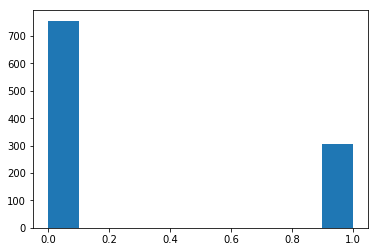

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])

df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

In [3]:
fps = rdkitDescriptors.batch_compute_rdkit_fingerprints(df['SMILES'])
len(fps[0])

2048

In [4]:
from dimreducer import DeepAutoEncoder as DAE

In [5]:
dims =[2048,1028,128]
autoencoder = DAE(dims, act='relu')
autoencoder.build_model(norm=False)
history = autoencoder.train_model(fps, norm_feature=False, epochs=50)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1063/1063 [==============================] - 1s 589us/step - loss: 0.0817
Epoch 2/50
1063/1063 [==============================] - 0s 300us/step - loss: 0.0726
Epoch 3/50
1063/1063 [==============================] - 0s 293us/step - loss: 0.0666
Epoch 4/50
1063/1063 [==============================] - 0s 292us/step - loss: 0.0602
Epoch 5/50
1063/1063 [==============================] - 0s 293us/step - loss: 0.0551
Epoch 6/50
1063/1063 [==============================] - 0s 296us/step - loss: 0.0502
Epoch 7/50
1063/1063 [==============================] - 0s 296us/step - loss: 0.0460
Epoch 8/50
1063/1063 [==============================] - 0s 298us/step - loss: 0.0425
Epoch 9/50
1063/1063 [==============================] - 0s 297us/step - loss: 0.0394
Epoch 10/50
1063/1063 [==============================] - 0s 297us/step - loss: 0.0367
Epoch 11/50
1063/1063 [======

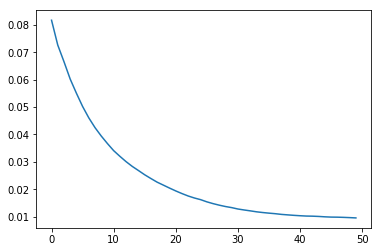

In [6]:
plt.plot(history.history['loss'])

### Visualization Using True label

Text(0.5, 1.0, 'Use Fingerprints from hidden layer')

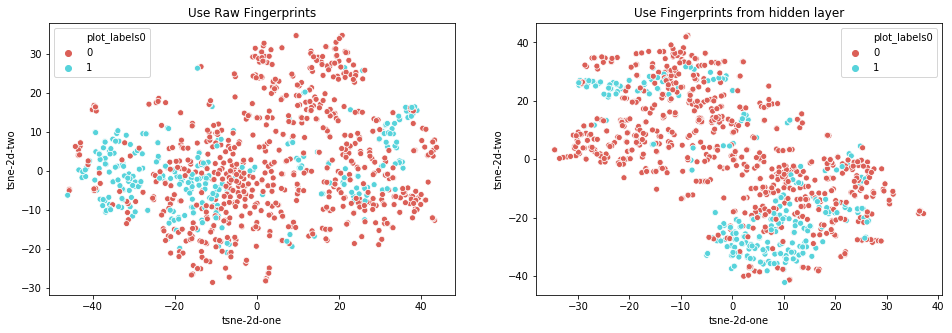

In [8]:
encoder = Model(inputs=autoencoder.model.input, 
                outputs=autoencoder.model.get_layer(name='embedding_layer').output)
hidden_feat = encoder.predict(fps)
fig, ax=plt.subplots(1,2,figsize=(16,5))
utilities.tsne_2d_visulization(fps, true_label_biclass, ax=ax[0], verbose=0)
utilities.tsne_2d_visulization(hidden_feat, true_label_biclass, ax=ax[1], verbose=0)
ax[0].set_title('Use Raw Fingerprints')
ax[1].set_title('Use Fingerprints from hidden layer')



### Use update_interval = 50

In [11]:
autoencoder_dims = [2048,1028,128]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50, clustering_tol=1e-3)

cl_weights = np.arange(0.1, 1, 0.1)
results = []
hidden_feats=[]

for cl_weight in cl_weights:
    dce.build_model(norm=False)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(fps,clustering_loss='kld', 
                               decoder_loss='binary_crossentropy',
                               training_prints=False,
                               norm_feature=False,
                               clustering_loss_weight=cl_weight)
    results.append(result_i)
    encoder = Model(inputs=dce.model.input, 
                    outputs=dce.model.get_layer(name='embedding_layer').output)
    
    hidden_feats.append(encoder.predict(fps))
    print('Training finished and the results are recorded')

Start to train model with cluster weight: 0.1
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0009407337723424271 < 0.001
Reached tolerance threshold. Stopping training.
Training finished and t

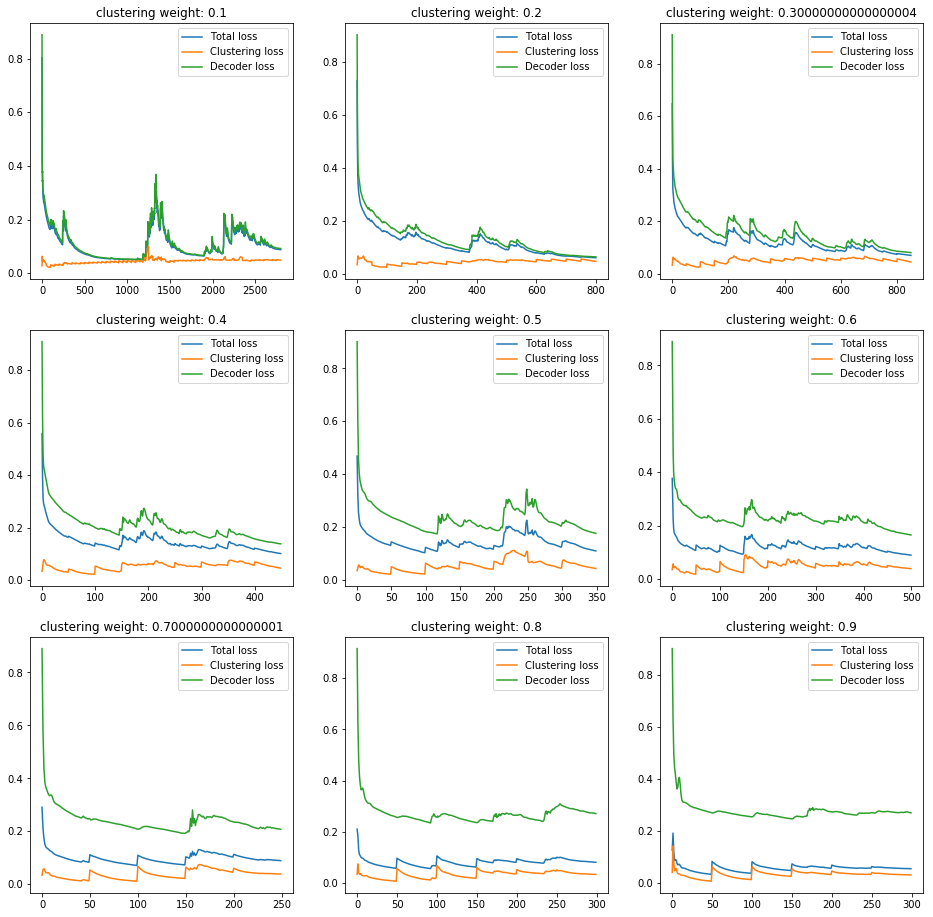

In [12]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][1][0],label='Total loss')
    ax[row_i][column_j].plot(results[i][1][1],label='Clustering loss')
    ax[row_i][column_j].plot(results[i][1][2],label='Decoder loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))


Text(0.5, 1.0, 'fowlkes_mallows_score')

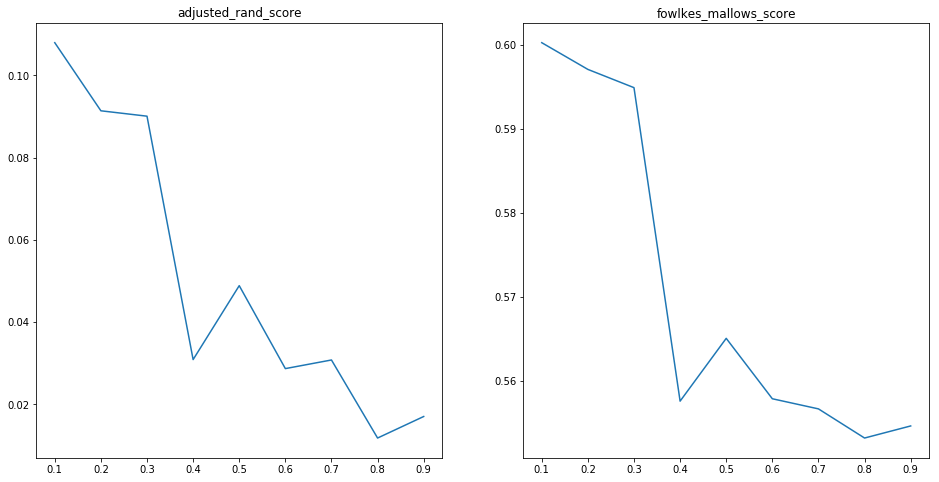

In [13]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(true_label_biclass,results[i][0],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(1,2,figsize=(16,8))

ax[0].plot(cl_weights,adjusted_rand_score)
ax[0].set_title('adjusted_rand_score')

ax[1].plot(cl_weights,fowlkes_mallows_score)
ax[1].set_title('fowlkes_mallows_score')

#### visualized by true label

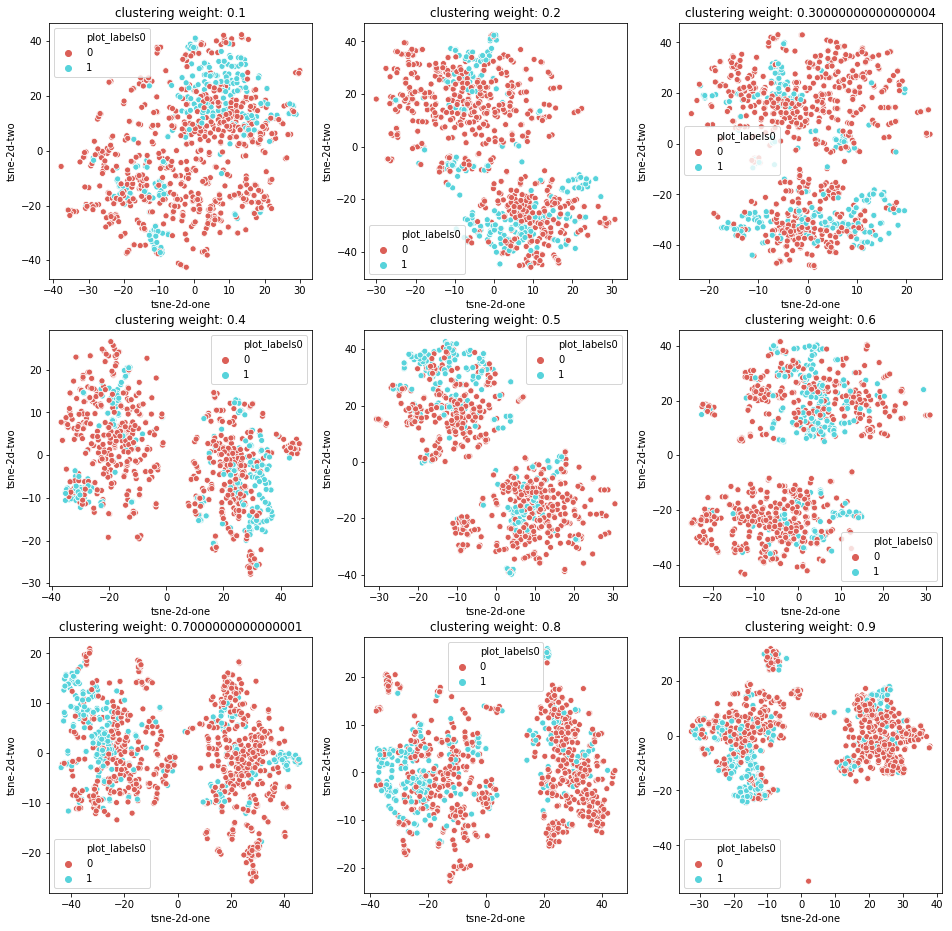

In [14]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization(input_feat=hidden_feats[i], 
                                   plot_labels=true_label_biclass,
                                   verbose=0,
                                   ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

#### visualized by predicted label

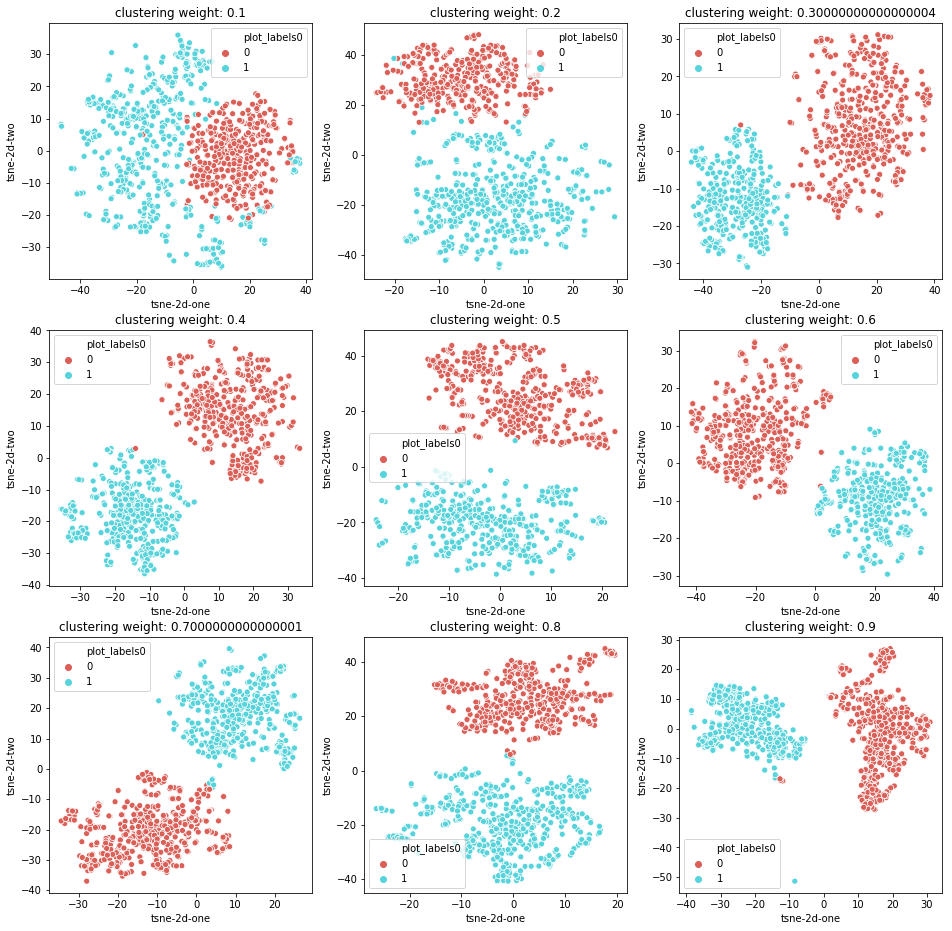

In [15]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization(input_feat=hidden_feats[i], 
                                   plot_labels=results[i][0],
                                   verbose=0,
                                   ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

### Use update_interval = 25

In [15]:
autoencoder_dims = [2048,512,128]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25)
cl_weights = np.arange(0.1, 1, 0.1)
results = []

for cl_weight in cl_weights:
    dce.build_model(norm=True)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(fps,clustering_loss='kld', 
                               decoder_loss='binary_crossentropy',
                               training_prints=False,
                               norm_feature=False,
                               clustering_loss_weight=cl_weight)
    results.append(result_i)
    print('Training finished and the results are recorded')


Start to train model with cluster weight: 0.1
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.7000000000000001

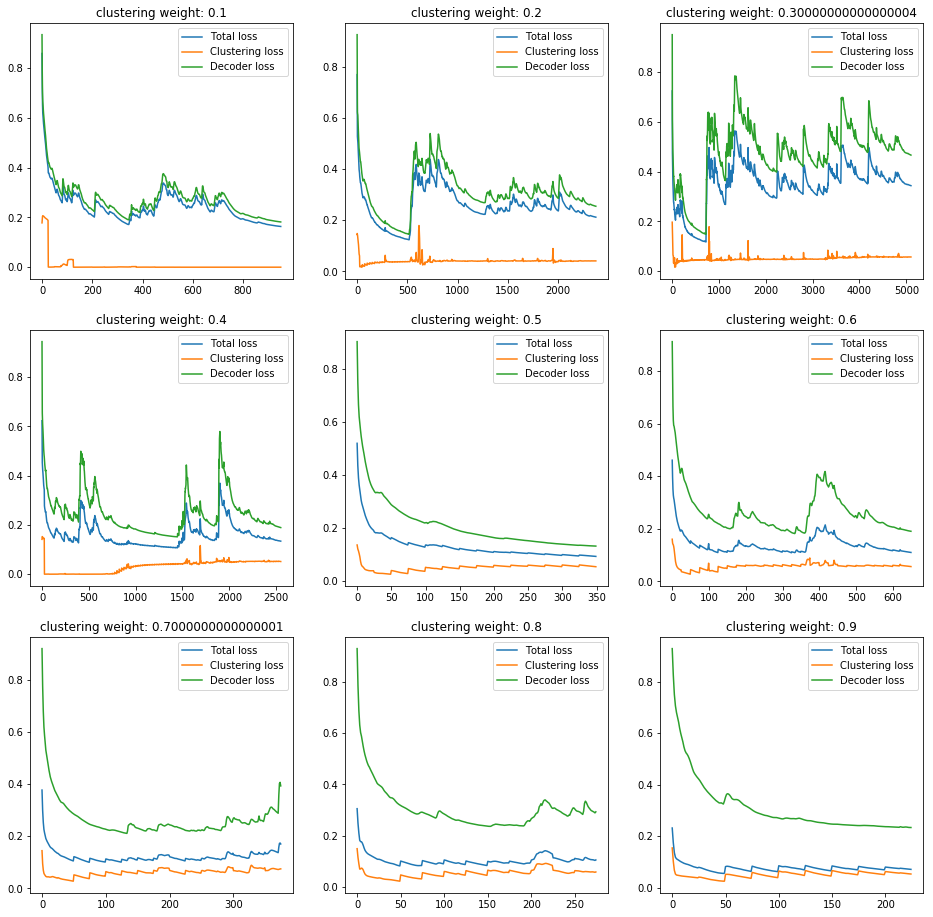

In [16]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][1][0],label='Total loss')
    ax[row_i][column_j].plot(results[i][1][1],label='Clustering loss')
    ax[row_i][column_j].plot(results[i][1][2],label='Decoder loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

Text(0.5, 1.0, 'fowlkes_mallows_score')

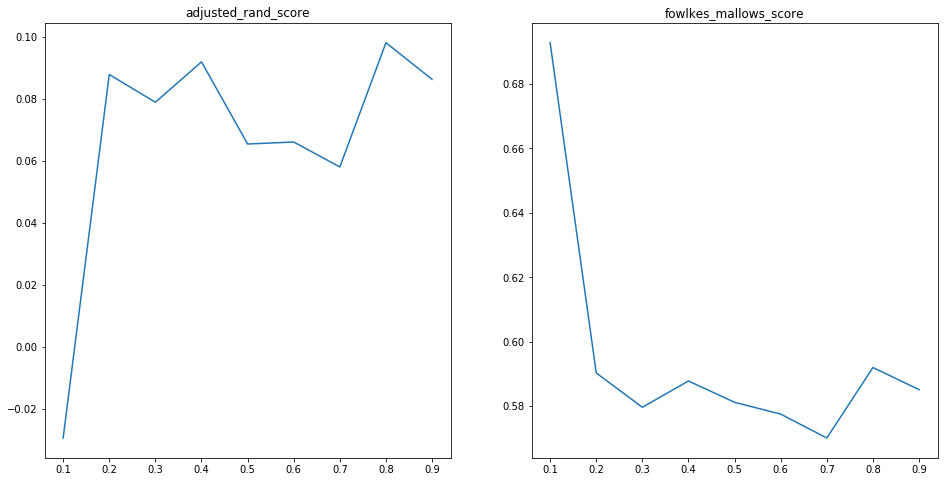

In [17]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(true_label_biclass,results[i][0],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(1,2,figsize=(16,8))

ax[0].plot(cl_weights,adjusted_rand_score)
ax[0].set_title('adjusted_rand_score')

ax[1].plot(cl_weights,fowlkes_mallows_score)
ax[1].set_title('fowlkes_mallows_score')

### Use update_interval = 10

In [18]:
autoencoder_dims = [2048,512,128]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=10)
cl_weights = np.arange(0.1, 1, 0.1)
results = []

for cl_weight in cl_weights:
    dce.build_model(norm=True)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    result_i = dce.train_model(fps,clustering_loss='kld', 
                               decoder_loss='binary_crossentropy',
                               training_prints=False,
                               norm_feature=False,
                               clustering_loss_weight=cl_weight)
    results.append(result_i)
    print('Training finished and the results are recorded')

Start to train model with cluster weight: 0.1
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.7000000000000001

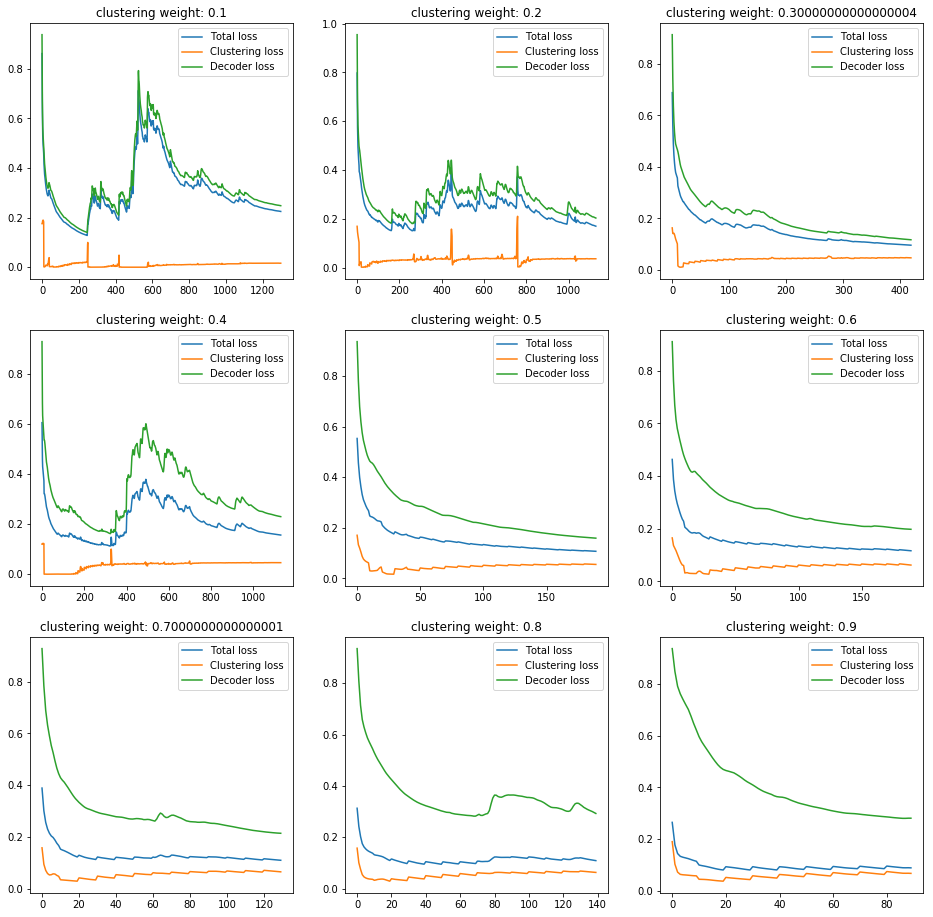

In [19]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    ax[row_i][column_j].plot(results[i][1][0],label='Total loss')
    ax[row_i][column_j].plot(results[i][1][1],label='Clustering loss')
    ax[row_i][column_j].plot(results[i][1][2],label='Decoder loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

Text(0.5, 1.0, 'fowlkes_mallows_score')

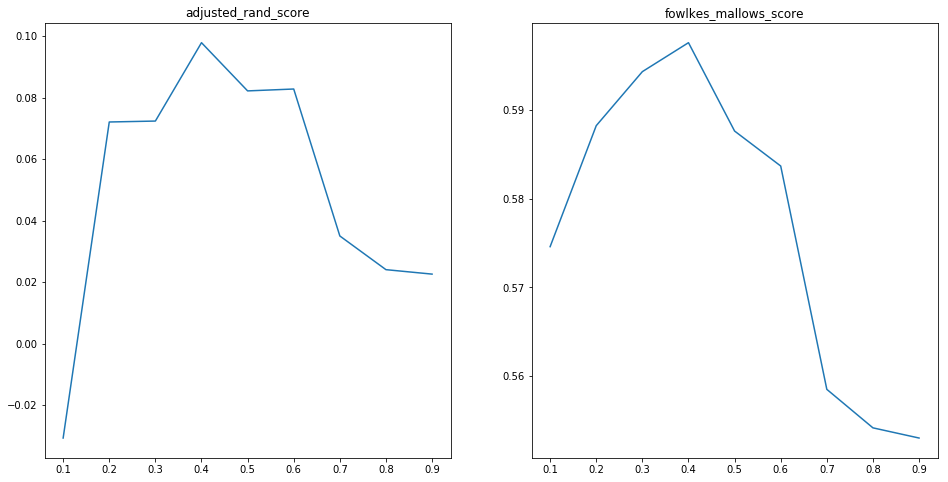

In [20]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(true_label_biclass,results[i][0],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(1,2,figsize=(16,8))

ax[0].plot(cl_weights,adjusted_rand_score)
ax[0].set_title('adjusted_rand_score')

ax[1].plot(cl_weights,fowlkes_mallows_score)
ax[1].set_title('fowlkes_mallows_score')